In [3]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

--2023-11-26 16:24:57--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-11-26 16:24:57--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: 'mallet-2.0.8.zip.1'

mallet-2.0.8.zip.1  100%[===================>]  15.43M  9.47MB/s    in 1.6s    

2023-11-26 16:24:59 (9.47 MB/s) - 'mallet-2.0.8.zip.1' saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [22]:
import os
import pandas as pd
import gensim
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim as gensimvis
from matplotlib import pyplot as pyplot
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



# preprocess a single tweet/text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    stop_words.add("embeddedurl")
    tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# evaluate the coherence for each number of topics in a range
def evaluate_coherence(corpus, dictionary, texts, num_topics_list):
    coherence_scores = []
    lda_models = []  # List to store LDA models

    for num_topics in num_topics_list:
        print(num_topics)
        # Create a new LDA model for each evaluation
        lda_model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        coherence = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
        coherence_scores.append((num_topics, coherence.get_coherence()))
        lda_models.append(lda_model)

    # Create a DataFrame to store the coherence scores
    coherence_df = pd.DataFrame(coherence_scores, columns=["Number of Topics", "Coherence Scores"])
    return coherence_df, lda_models


# load the data and transform to DataFrame
df = pd.read_csv(".././data/full_year.csv")
df['tokenized_text'] = df['clean_text'].apply(preprocess_text)

# create vocabulary and doc2box doc-term matrix
dictionary = Dictionary(df['tokenized_text'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['tokenized_text']]

# path to the Mallet executable
mallet_path = 'mallet-2.0.8/bin/mallet'

# run and save the model
num_topics = 10 
lda = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary)
os.makedirs('models', exist_ok=True)
lda.save(os.path.join('models', 'lda_religion_spirituality'))

# calculate coherence and save to csv
num_topics_list = list(range(2, 16, 1))
coherence_scores, lda_models = evaluate_coherence(doc_term_matrix, dictionary, df['tokenized_text'], num_topics_list)

# save all the LDA models
for i, model in enumerate(lda_models):
    model.save(os.path.join('models', f'lda_religion_spirituality_{num_topics_list[i]}_topics'))

os.makedirs('coherence', exist_ok=True)
coherence_scores.to_csv(os.path.join('coherence', 'coherence_religion_spirituality.csv'), index=False)

[nltk_data] Downloading package punkt to /Users/shtosti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shtosti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shtosti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.76608
<20> LL/token: -10.48348
<30> LL/token: -10.15966
<40> LL/token: -9.91966

0	5	religion world country spirituality history living science people dharma study class philosophy positive case culture due blessing psychology century pay 
1	5	religion people hindu state religious free law freedom government make politics india muslim church christian political belief hate party wrong 
2	5	god spirituality love religion islam faith heart jesus allah youtube divine alratv muslim younusa

2


Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -9.42914
<20> LL/token: -9.38259
<30> LL/token: -9.33964
<40> LL/token: -9.29708

0	25	religion spirituality people god love life book spiritual islam faith make rt thing science muslim world good christian belief hindu 
1	25	spirituality religion people spiritual meditation life god world love hard time inspiration wisdom se ji sagittarius day religious yoga labeling 

<50> LL/token: -9.25313
<60> LL/token: -9.21058
<70> LL/token: -9.16159
<80> LL/token: -9.10585
<90> LL/token: -9.05173

0	25	religion people god book religious muslim christian islam make hindu thing belief freedom faith church good country christianity race politics 
1	25	spirituality spiritual life love religion world meditation peace day hard rt true time soul wisdom se inspiration ji sagittarius healing 

<100> LL/token: -9.00688
<110> LL/token: -8.97299
<120> LL/token: -8.94779
<130> LL/token: -8.92952

3


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -9.78027
<20> LL/token: -9.69769
<30> LL/token: -9.61174
<40> LL/token: -9.52395

0	16.66667	religion spirituality god people love hard faith se sagittarius islam christian labeling muslim religious jesus rt heart church life make 
1	16.66667	religion spirituality people world ji true life make rt thing history gt humanity saint time country human god love science 
2	16.66667	spirituality religion spiritual meditation life love people book wisdom yoga inspiration mindfulness healing happiness freedom time thing consciousness day free 

<50> LL/token: -9.43514
<60> LL/token: -9.34697
<70> LL/token: -9.2589
<80> LL/token: -9.18392
<90> LL/token: -9.12674

0	16.66667	religion god people faith christian muslim islam hard hindu church se sagittarius religious labeling jesus belief state woman culture christianity 
1	16.66667	religion people world make true ji thing time human d

4


Mallet LDA: 4 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.02361
<20> LL/token: -9.90536
<30> LL/token: -9.78129
<40> LL/token: -9.6446

0	12.5	spirituality god love spiritual religion peace faith meditation islam life soul healing world heart wisdom quote energy youtube consciousness motivation 
1	12.5	religion spirituality people book hindu history life freedom gt time rt experience science real religious thing work make based india 
2	12.5	spirituality religion people life hard se sagittarius labeling ji yoga meditation true day spiritual mindfulness world happiness make thing humanity 
3	12.5	religion people spirituality muslim human christian christianity bible race support culture follow woman year time thing rt life religious gender 

<50> LL/token: -9.51434
<60> LL/token: -9.40341
<70> LL/token: -9.31296
<80> LL/token: -9.2442
<90> LL/token: -9.18968

0	12.5	spirituality god love spiritual meditation life faith peace s

5


Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.20862
<20> LL/token: -10.06521
<30> LL/token: -9.91924
<40> LL/token: -9.76911

0	10	spirituality god religion love spiritual faith ji peace soul islam life true humanity heart history saint knowledge follow allah divine 
1	10	spirituality religion meditation spiritual hard se inspiration sagittarius wisdom labeling yoga mindfulness life happiness healing gt health consciousness support rt 
2	10	religion spirituality world people country thing make love life living time religious tarot christian day good rt astrology reading dharma 
3	10	religion spirituality people hindu culture time thing make race religious muslim woman politics church good christian day state rt belief 
4	10	religion spirituality people book life science freedom christianity religious bible hope experience work thing make christian read world belief good 

<50> LL/token: -9.62783
<60> LL/token: -9

6


Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.35721
<20> LL/token: -10.19527
<30> LL/token: -10.01194
<40> LL/token: -9.83162

0	8.33333	spirituality religion life spiritual ji humanity world day work true saint people experience path real today mind make book great 
1	8.33333	religion people religious hindu india belief thing state spirituality christian muslim culture country respect time race church political politics man 
2	8.33333	religion god spirituality love faith spiritual islam heart jesus muslim history peace allah youtube support divine alratv younusalgohar soul human 
3	8.33333	spirituality religion life meditation yoga spiritual mindfulness people happiness wisdom inspiration health video based gender inspirational book good science truth 
4	8.33333	spirituality religion love healing peace free meditation world quote people country life living energy bible freedom motivation reading art enlightenmen

7


Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.47837
<20> LL/token: -10.28678
<30> LL/token: -10.06911
<40> LL/token: -9.88992

0	7.14286	spirituality true religion god ji day humanity spiritual follow life saint path knowledge reading soul guru tarot astrology people world 
1	7.14286	religion spirituality people thing health time find good culture land make part life lot woman rt learning science family stop 
2	7.14286	spirituality religion meditation spiritual yoga mindfulness happiness wisdom life inspiration rt video people mind gt consciousness inspirational time mooji science 
3	7.14286	religion people hard spirituality se sagittarius labeling religious support muslim belief race politics human woman year thing church hate state 
4	7.14286	religion spirituality god love islam heart book spiritual history science faith alratv divine allah younusalgohar goharshahi sufism people gender life 
5	7.14286	spiritual

8


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.58777
<20> LL/token: -10.3517
<30> LL/token: -10.07168
<40> LL/token: -9.87084

0	6.25	religion spirituality people freedom science hope god life universe islam connection muslim make good thing rt belief day terrorist faith 
1	6.25	spirituality religion life follow christianity book people understand art respect gender join kindle read knowledge live true color work rt 
2	6.25	religion spirituality people life god find time rt thing woman religious music free happy check good reason feeling christian relationship 
3	6.25	religion spirituality world human support people muslim thing year religious india time end islam american god country voice century racism 
4	6.25	religion spirituality book history gt people church business science christian class study state case political faith online due psychology law 
5	6.25	spirituality love spiritual god meditation peace lif

9


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.68479
<20> LL/token: -10.44771
<30> LL/token: -10.1811
<40> LL/token: -9.92791

0	5.55556	religion spirituality life freedom work real experience book race find gender people good color guide success sex thing social woman 
1	5.55556	religion people christian bible based religious spirituality land church law belief state woman school caste truth thing muslim good mass 
2	5.55556	religion people support muslim human politics hindu culture hate belief white issue voice racism race religious year stop group state 
3	5.55556	religion spirituality read people free thing time respect life rt family african make feel india person youtube world year human 
4	5.55556	spirituality religion world country gt quote follow motivation living peace enlightenment love healing understand book people awareness dharma blessing business 
5	5.55556	spirituality religion ji day science tr

10


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.76592
<20> LL/token: -10.50741
<30> LL/token: -10.20682
<40> LL/token: -9.93863

0	5	religion people freedom race human respect gender based belief system color terrorist muslim group good thing islamic thinking hate peaceful 
1	5	spirituality religion world country living people dharma blessing positive good time learning thing rt make awareness family land music question 
2	5	religion spirituality day ji humanity true world saint hindu people great path guru caste life maharaj today million taught gurmeetramrahim 
3	5	religion religious people india muslim support world spirituality american make indian human man year century voice racism belief entire hindu 
4	5	religion spirituality history science read book join youtube philosophy class study online case art due time podcast link psychology pay 
5	5	god spirituality love faith spiritual religion peace heart jes

11


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.83358
<20> LL/token: -10.54607
<30> LL/token: -10.23862
<40> LL/token: -9.97016

0	4.54545	religion people spirituality muslim religious na race christian time thing rt based fight question islam god make hindu matter belief 
1	4.54545	spirituality spiritual love meditation life peace wisdom inspiration healing yoga mindfulness happiness quote consciousness video energy motivation soul spiritualawakening awakening 
2	4.54545	religion people black hate stop terrorist politics spirituality country islamic based thing respect religious rule woman peaceful hindu leader mass 
3	4.54545	religion spirituality history science philosophy book study business class case due online join psychology pay service podcast feeling research paper 
4	4.54545	spirituality religion hard se sagittarius labeling freedom free world real india work life experience make religious book great l

12


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.89972
<20> LL/token: -10.59324
<30> LL/token: -10.27627
<40> LL/token: -10.01283

0	4.16667	spirituality love peace meditation healing world quote consciousness life motivation inspiration living country spiritualawakening enlightenment energy awareness wisdom dharma blessing 
1	4.16667	religion spirituality hard se sagittarius labeling people ji god india religious maharaj world man true rampal sant great war prophet 
2	4.16667	religion christian jesus bible church spirituality race people god gender life catholic worship christ human color pray faith belief time 
3	4.16667	spirituality spiritual meditation yoga mindfulness happiness wisdom gt life video world inspiration health nature mind inspirational mooji youtube read religion 
4	4.16667	religion hindu book people spirituality science muslim hope universe indian connection kindle caste christianity hinduism le

13


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -10.96037
<20> LL/token: -10.62773
<30> LL/token: -10.26785
<40> LL/token: -9.97791

0	3.84615	spirituality meditation spiritual inspiration yoga wisdom mindfulness life happiness health video nature motivation quote mind consciousness inspirational mooji healing body 
1	3.84615	spirituality world religion country living india awareness religious dharma man people blessing rt end peace positive enlightenment century human american 
2	3.84615	religion thing people spirituality make belief men time good black kid point question ppl white politics feel left made talk 
3	3.84615	spirituality day ji true humanity saint great religion path today guru life maharaj million teaching power make taught holy gurmeetramrahim 
4	3.84615	spirituality religion follow gt tarot astrology understand reading energy time start message sign psychic relationship knowledge space manifestation 

14


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -11.01664
<20> LL/token: -10.67519
<30> LL/token: -10.31605
<40> LL/token: -10.02422

0	3.57143	religion people culture society church atheist spirituality christian white secular wrong reason part belief thing sin ca religious point catholic 
1	3.57143	religion spirituality people religious india end woman african american medium entire feel thing man century good world black force bad 
2	3.57143	religion spirituality people science connection youtube hope universe visit step channel evolution read time rt practice reality talk changing subscribe 
3	3.57143	spirituality world religion country gt love living peace dharma people awareness blessing positive life system start thinking rt business global 
4	3.57143	religion history spirituality science find study class philosophy case due politics psychology political pay online crystal free research paper school 
5	3.57143

15


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 76
total tokens: 2951035
<10> LL/token: -11.0706
<20> LL/token: -10.69125
<30> LL/token: -10.32402
<40> LL/token: -10.04353

0	3.33333	god love spirituality faith spiritual islam soul jesus heart peace allah prayer divine alratv truth younusalgohar full goharshahi sufism awakening 
1	3.33333	spirituality meditation spiritual life yoga mindfulness happiness wisdom inspiration health consciousness video mind inspirational mooji energy growth body vedanta join 
2	3.33333	spirituality religion find spirit reading medium tarot war day free psychic podcast light time world sound life crystal happy pm 
3	3.33333	religion people bible spirituality respect christian church terrorist jew islamic worship peaceful power islam israel rt music pretty nation scripture 
4	3.33333	religion spirituality work life experience real book check make thing good feel guide time people read lifestyle freedom african success 
5	3.33333

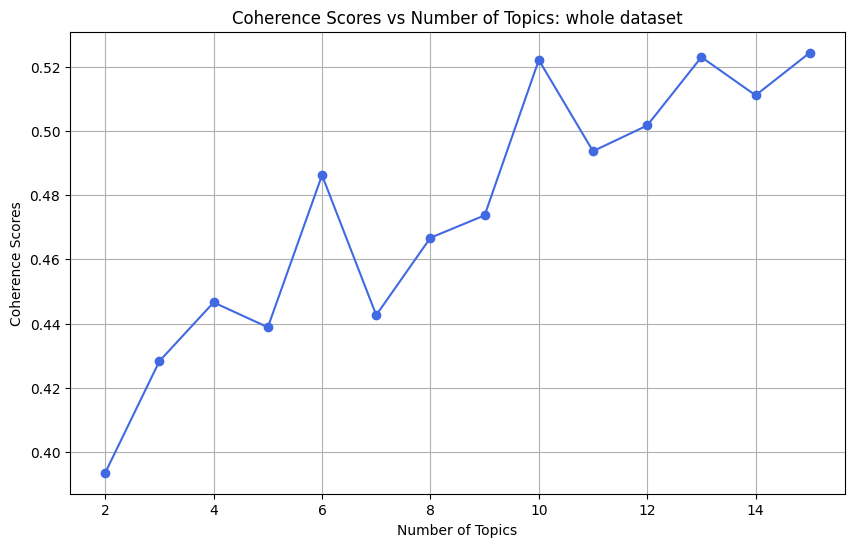

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_coherence contains your data
# If not, replace it with your actual DataFrame
df_coherence = pd.read_csv("./coherence/coherence_religion_spirituality.csv")

# Extracting data from the DataFrame
num_topics = df_coherence['Number of Topics']
coherence_scores = df_coherence['Coherence Scores']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_topics, coherence_scores, marker='o', linestyle='-', color='royalblue')
plt.title('Coherence Scores vs Number of Topics: whole dataset')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.grid(True)

output_folder = os.path.join('coherence', 'coherence_png')
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, 'coherence_religion_spirituality.png')
plt.savefig(output_path)

plt.show()

In [ ]:
html_dir = 'visualizations'
os.makedirs(html_dir, exist_ok=True)


# 6 topics
# load the Mallet LDA model
lda_model_mallet = LdaMallet.load('models/lda_religion_spirituality_6_topics')
# convert Mallet LDA model to Gensim LDA model
lda_model_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_mallet)
# save to html
vis_data = gensimvis.prepare(lda_model_gensim, doc_term_matrix, dictionary)
html_filename = os.path.join(html_dir, 'lda_religion_spirituality_6_topics.html')
pyLDAvis.save_html(vis_data, html_filename)


# 10 topics
# load the Mallet LDA model
lda_model_mallet = LdaMallet.load('models/lda_religion_spirituality_10_topics')
# convert Mallet LDA model to Gensim LDA model
lda_model_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_mallet)
# save to html
vis_data = gensimvis.prepare(lda_model_gensim, doc_term_matrix, dictionary)
html_filename = os.path.join(html_dir, 'lda_religion_spirituality_10_topics.html')
pyLDAvis.save_html(vis_data, html_filename)


# 15 topics
# load the Mallet LDA model
lda_model_mallet = LdaMallet.load('models/lda_religion_spirituality_15_topics')
# convert Mallet LDA model to Gensim LDA model
lda_model_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_mallet)
# save to html
vis_data = gensimvis.prepare(lda_model_gensim, doc_term_matrix, dictionary)
html_filename = os.path.join(html_dir, 'lda_religion_spirituality_15_topics.html')
pyLDAvis.save_html(vis_data, html_filename)
